# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [36]:
import torch
import torch.nn as nn   # 다양한 Layer / model 들이 정의된 패키지. (Neural Network)
from torch.utils.data import DataLoader  # DataLoader 클래스 -> 모델에 데이터들을 제공하는 역할.
from torchvision import datasets, transforms
# torchvision 패키지(라이브러리):pytorch의 image 전용 sub package
### datasets(모듈): vision(영상) 데이터셋들을 제공하는 모듈
### transformers: 이미지(영상) 전처리 기능들을 제공하는 모듈
import matplotlib.pyplot as plt


In [37]:
torch.__version__

'2.5.1+cpu'

### device 설정

In [38]:
# 어느 Device 에서 연산처리 할지 지정. (cpu, cuda(GPU))
# device = "cpu"
print(torch.cuda.is_available())  # cuda를 사용할 수 있는 환경인지 조회
device = "cuda" if torch.cuda.is_available() else "cpu"  # 2.0이전: torch.Device("cuda")
print(device)

False
cpu


In [39]:
# MAC OS ("cpu", "mps")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


### 하이퍼파라미터, 변수 설정

In [40]:
lr = 0.001  # 학습률. 0 ~ 1 실수.
batch_size = 256  # 모델로 학습할 떄 한번에 몇개의 데이터를 제공할 지 개수.
# step: 모델의 파라미터들을 update 하는 단위. (1 step: batch_size(256)만큼의 데이터로 parameter update)
# epoch: train set 전체를 학습하는 단위. (1 epoch: 총 데이터 개수(60,000개)를 한번 다 학습한 것.)
epochs = 20

In [41]:
60000 / 256 * 20

4687.5

In [42]:
import os
# 학습이 끝난 모델을 저장할 디렉토리.
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Dataset을 저장할 디렉토리
dataset_dir = "datasets/mnist"
os.makedirs(dataset_dir, exist_ok=True)

In [43]:
# git에 업로드 되지 않게 하는 방법.
# datasets/, models/ .so/  --> git ignore 파일에 작성해주면, 업로드를 안되게 할 수 있음.

### MNIST dataset Loading

#### Dataset

In [44]:
trainset = datasets.MNIST(
    root=dataset_dir, # dataset을 읽어올 디렉토리. 
    download=True,    # root 에 dataset이 없을 경우 다운로드 받으지 여부.
    transform=transforms.ToTensor()

)  # torchvision 에서 import 한 것.
testset = datasets.MNIST(
    root=dataset_dir,
    download=True,
    train=False,       # Trainset 인지 여부. True(default): train set,  False: test set
    transform=transforms.ToTensor()
)

# transform=함수 -> input data를 전처리 하는 함수를 전달. 
# transform.ToTensor. class 객체를 전달함.
## ndarray, PIL.Image 객체를 torch.Tensor 로 변환.
## (height, width, channel) 순서를 channel first (channel, height, width) 형태로 변환.
## pixcel값( 0~ 255정수) 들을 0 ~ 1 로 정규화. (Feature Scaling - MinMaxScaling)

In [45]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets/mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

In [46]:
# 개별데이터 조회
trainset[0]  # tuple: (X, y)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
trainset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [48]:
import numpy as np
a = np.array(trainset[0][0])  # PIL.Image -> ndarray
print(a.shape)
a.min, a.max() 

(1, 28, 28)


C:\Users\Playdata\AppData\Local\Temp\ipykernel_15608\3670598540.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  a = np.array(trainset[0][0])  # PIL.Image -> ndarray


(<function ndarray.min>, np.float32(1.0))

In [49]:
#######################3 transforms.ToTensor() 적용 후##############################

f1 = trainset[0][0]
print(f1.shape)    # ( 1: channel- grayscale,  28: height, 28:width)
print(f1.dtype, f1.type())
print(f1.min(), f1.max())

torch.Size([1, 28, 28])
torch.float32 torch.FloatTensor
tensor(0.) tensor(1.)


60000


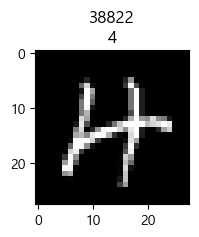

In [50]:
# 시각화
import random
print(len(trainset))
idx = random.randint(0, len(trainset))  # 0 ~ 60,000 사이 랜덤 정수를 반환.
img, label = trainset[idx]

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze(), cmap="gray") # (1, 28, 28) -> (28, 28) . # matplotlib 은 이미지를 (h, w, c) 로 전달해야함.
plt.title(f"{idx}\n{label}")
plt.show()


In [51]:
# 객체를 함수처럼 사용.
class Test:

    def test(self):
        print("Test객체.test()")


t = Test()
t.test()

Test객체.test()


In [52]:
# 객체를 함수처럼 사용.
class Test:

    def __call__(self):
        print("Test객체.test()")


t = Test()
t()   # t.__call__():  --> callable (함수, 메소드, __call__() 정의한 객체)

Test객체.test()


#### DataLoader

In [53]:
# DataLoader : Dataset 의 데이터들을 모델에 제공하는 역할. 데이터들을 모델에 어떻게 제공할지 설정해서 생성.
## Dataset: 데이터들을 가지고 있는 역할. 하나씩 조회하는 기능을 제공. 
train_loader = DataLoader(
    trainset,  # Dataset
    batch_size=batch_size, # batch size(256)
    shuffle=True , # 모델에 데이터를 제공하기 전에 섞을지 여부. (default: False) True: 한 epoch 학습전에 섞는다.
    drop_last=True,  # 모델에 제공할 데이터의 개수가 batch_size 보다 적으면 제공하지 않는다.(학습에 사용안함.)
)

test_loader = DataLoader(testset, batch_size=batch_size)


In [54]:
# 1 epoch 당 step수
len(train_loader), len(test_loader)

(234, 40)

In [55]:
# 데이터 개수.
len(trainset), len(testset)

(60000, 10000)

### 모델 정의

In [56]:
# subclass(상속) 방식
## nn.Module 상속한 클래스를 정의
## __init__(): 순전파 연산(추론)에 필요한 layer들을 생성.
## forward(): 연산 로직을 정의

In [57]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__() # 상위 클래스의 nn.Module을 초기화.
        # 입력 input feature 개수, 출력 output 
        # 첫번째 Linear() : 입력데이터(X_train)을 입력. (input- 입력데이터 feature 수에 맞춘다.)
        self.lr1 = nn.Linear(784, 128)  # (784: image의 pixcel 수, 출력: 128)  출력은 찾은 특징으로, 차원을 축소한 값? 이라고 보면 된다.
        self.lr2 = nn.Linear(128, 64)   # (128: lr1 의 출력개수, 출력: 64)
        self.lr3 = nn.Linear(64, 32)    # (64: lr2 의 출력개수, 출력: 32)
        self.lr4 = nn.Linear(32, 10)    # (32: lr3 의 출력개수, 출력: 10 -> y의 class 개수.)
    # 마지막 Linear(): 출력 크기(10 - )
    def forward(self, X):
        """X를 입력 받아서 y를 추론하는 계산로직을 정의
        initializer에서 정의한 Linear들을 이용해서 계산.
        parameter:
            X: torch.FloatTensor - 추론할 MNIST 이미지들.
                                   Shape: (batch_size, 1, 28, 28) - batch_size 개수의 이미를 받아서 추론.
        """
        # (batch_size, 1, 28, 28) 를 (batch_size, 784) Feature들을 1차원으로 변환.
        X = torch.flatten(X, start_dim=1) # 다차원 배열을 1차원 배열로 변환. (start_dim=1, 0축은 놔두고 1축 부터 flatten 시킨다.)
        X = self.lr1(X)   # 정의된 선형 변환 레이어
        X = nn.ReLU()(X)  # 객체를 호출, 비선형 함수. 선형 레이어의 출력에 ReLU(Rectified Linear Unit) Activation(활성화) 함수를 적용
        X = self.lr2(X)
        X = nn.ReLU()(X)  # 비선형성을 추가하여 네트워크의 표현력을 높힘. 비선형함수.ReLU(x) - max(x, 0)
        X = self.lr3(X)
        X = nn.ReLU()(X)
        output = self.lr4(X)
        return output


#### ReLU: rectified linear unit (렐루, 정류 선형 유닛, 정류 선형 단위)
        # ReLU(렐루)는 인공신경망에서 사용되는 활성화 함수의 일종이다. ReLU의 수학적 표현은 f(x) = max(0, x)로, 
        # 입력값이 0보다 크면 그 값을 그대로 출력하고, 0 이하면 0을 출력한다. 
        # 이 단순한 비선형성 때문에, ReLU는 신경망의 학습 속도를 개선하고, 
        # 이전에 많이 사용되던 시그모이드 함수나 하이퍼볼릭 탄젠트 함수보다 효율적으로 깊은 네트워크를 학습시킬 수 있다.

        # ReLU의 주된 장점은 계산 효율성과 비선형적 특성 때문에 더 복잡한 함수를 모델링할 수 있다는 것이다. 
        # 그러나 ReLU는 '죽은 뉴런' 문제를 가지고 있는데, 이는 네트워크의 일부 뉴런이 학습 과정에서 더 이상 활성화되지 않는 현상을 말한다. 
        # 이를 해결하기 위해 Leaky ReLU, Parametric ReLU 등의 변형된 ReLU 함수들이 개발되었다.

In [58]:
##### flatten() 함수 테스트
v = torch.arange(30).reshape(5, 2, 3)
print(v.shape)
v2 = torch.flatten(v, start_dim=1)
v2.shape

torch.Size([5, 2, 3])


torch.Size([5, 6])

In [59]:
v2

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29]])

### Train

#### 모델, loss function, optimizer 생성

In [60]:
# 모델 객체 생성. device로 옮김.
model = MNISTModel().to(device) # 이 모델(의 파라미터들)의 연산을 처리할 device(cpu, cuda)로 이동.
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


In [61]:
nn.Linear()
W = torch.tensor(r_g=True, device="cpu")
X @ W + B

TypeError: Linear.__init__() missing 2 required positional arguments: 'in_features' and 'out_features'

In [62]:
# loss 함수
## 다중 분류 문제 -> crossentropy loss 함수를 이용. (이진분류: binary crossentropy, 회귀: mse)
loss_fn = nn.CrossEntropyLoss() # torch.nn.functional.cross_entropy 함수.

In [63]:
# optimizer 정의 -> 파라미터 업데이트, 파라미터의 gradient 값을 초기화.
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # (모델의 파라미터들, 학습률)

In [64]:
########### 생성한 모델로 학습전 추론.###########
# Data
X_batch, y_batch = next(iter(train_loader))  # batch_size 만큼 데이터를 추출, (X, y)
X_batch.shape, y_batch.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [65]:
# X, y를 model과 같은 device로 이동.
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

In [66]:
y_pred = model(X_batch)

In [67]:
# 첫번째 데이터의 예측결과
y_pred[0]  # 가장 큰값을 가진 index가 예측 class 가 된다.

tensor([-0.0743,  0.1555, -0.1143, -0.0282, -0.1155, -0.1220,  0.0166, -0.0582,
         0.0727, -0.2422], grad_fn=<SelectBackward0>)

In [68]:
y_pred[0].argmax()

tensor(1)

In [69]:
y_pred.argmax(dim=-1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [70]:
y_batch

tensor([2, 3, 1, 0, 7, 6, 3, 0, 9, 3, 4, 2, 9, 8, 9, 1, 3, 4, 6, 0, 8, 2, 5, 4,
        5, 6, 7, 6, 2, 8, 7, 9, 6, 3, 3, 8, 5, 8, 7, 4, 8, 2, 8, 6, 7, 1, 9, 6,
        3, 8, 7, 6, 7, 3, 8, 7, 2, 2, 2, 7, 2, 0, 4, 6, 5, 8, 5, 5, 1, 7, 0, 0,
        9, 5, 3, 9, 3, 8, 1, 5, 9, 1, 1, 3, 2, 3, 8, 9, 4, 8, 1, 8, 3, 6, 8, 5,
        6, 6, 1, 4, 2, 4, 8, 9, 0, 0, 6, 8, 6, 4, 8, 9, 4, 9, 0, 1, 8, 2, 3, 2,
        0, 2, 8, 8, 4, 9, 2, 5, 7, 8, 1, 0, 9, 8, 8, 1, 9, 6, 3, 1, 7, 9, 6, 3,
        2, 8, 3, 9, 3, 2, 0, 3, 6, 8, 0, 9, 6, 4, 2, 1, 1, 7, 8, 0, 7, 0, 0, 6,
        6, 4, 1, 1, 1, 2, 4, 3, 0, 9, 6, 4, 1, 9, 6, 2, 4, 8, 6, 7, 1, 4, 8, 2,
        7, 2, 8, 1, 0, 8, 2, 2, 5, 4, 6, 3, 2, 5, 0, 6, 6, 9, 5, 2, 0, 5, 9, 7,
        7, 4, 9, 3, 6, 4, 1, 4, 7, 3, 3, 8, 9, 4, 4, 9, 2, 4, 7, 3, 9, 1, 5, 9,
        9, 2, 2, 6, 3, 7, 9, 1, 7, 0, 8, 2, 6, 0, 4, 6])

In [71]:
# 오차 계산
loss = loss_fn(y_pred, y_batch)
loss

tensor(2.3041, grad_fn=<NllLossBackward0>)

In [72]:
# 모델 파라미터 업데이트
## gradient
loss.backward()
## 업데이트
optimizer.step()

In [73]:
## 파라미터 gradient 초기화
optimizer.zero_grad()
################################################ 1 step 학습.

#### 학습(훈련-train) 및 검증

In [74]:
# device 로 이동할 대상: Model객체, X(input), y(output) => 항상 같은 device에 위치해야함.

In [75]:
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
oprtimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [76]:
import time
# 학습
## epoch별 검즘결과들을 저장할 리스트.
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

# 학습-중첩 반복문: epoch 반복 -> step(batch_size) 에 대한 반복
for epoch in range(epochs):
    #########################################
    # 모델 Train - 1 epoch : Trainset
    #########################################
    model.train() # 모델을 train 모드로 변환.
    train_loss = 0 # 현재 epoch의 train loss 를 저장할 변수.

    # batch 단위로 학습 -> 1 step: 1개 batch의 데이터로 학습.
    for X_train, y_train in train_loader: # 한번 반복할 때마다 1개 batch 데이터를 순서대로 제공.
        # 1. device로 이동
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델을 이용해 추론
        pred = model(X_train)  # Model.forward(X_train) 메소드 호출
        # 3. loss 계산
        loss = loss_fn(pred, y_train)
        # 4. gradient 계산
        loss.backward()
        # 5. 모델의 파라미터들(weight, bias) update
        optimizer.step()
        # 6. gradient 초기화
        optimizer.zero_grad()
        #-----------------------1 step 학습 
        train_loss = train_loss + loss.item() # 학습 결과 저장 및 출력을 위해  loss 저장.
       
    train_loss = train_loss / len(train_loader)  # 1 epoch 학습한 loss 평균 계산.
    train_loss_list.append(train_loss)
 # 1 epoch 끝남.


    ########################################
    # 1 epoch 학습한 결과 검증 : Testsets
    ########################################
    model.eval()  # 모델을 evaluaton() (추론, 검증) 모드로 변환.
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad(): # 추론만 함 -> gradient 계산할 필요가 없음. -> grad_fn 구할 필요없음.
        for X_valid, y_valid in test_loader:
            # 1. device 로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            # 2. 추론
            pred_valid = model(X_valid)
            # 3-1. 검증 -> loss
            valid_loss = valid_loss = loss_fn(pred_valid, y_valid).item()
            # 3-2. 검증 -> accuracy
            ## pred_valid shape: (256, 10: class별 확률) -> 정답 class 추출
            pred_valid_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
        # 검증결과 누적갑의 평균
        valid_loss = valid_loss / len(test_loader) # step수 나눔.
        valid_acc = valid_acc / len(testset)       # data 개수로 나눔.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)


        # 검증 결과 출력
        print(f"[{epoch+1:02d}/{epochs}] train_loss: {train_loss}, valid_loss: {valid_loss}, valid_acc: {valid_acc}")
            
e = time.time()
print('학습에 걸린 시간(초):', e-s)

[01/20] train_loss: 2.314736825788123, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[02/20] train_loss: 2.3147159152560763, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[03/20] train_loss: 2.3147035419431505, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[04/20] train_loss: 2.314720408529298, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[05/20] train_loss: 2.314693041336842, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[06/20] train_loss: 2.314666099018521, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[07/20] train_loss: 2.3147189668101125, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[08/20] train_loss: 2.3146791743417072, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[09/20] train_loss: 2.3146693339714637, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[10/20] train_loss: 2.314687546501812, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[11/20] train_loss: 2.314682244235634, valid_loss: 0.05774564146995544, valid_acc: 0.0982
[12/2

#### 학습 로그 시각화

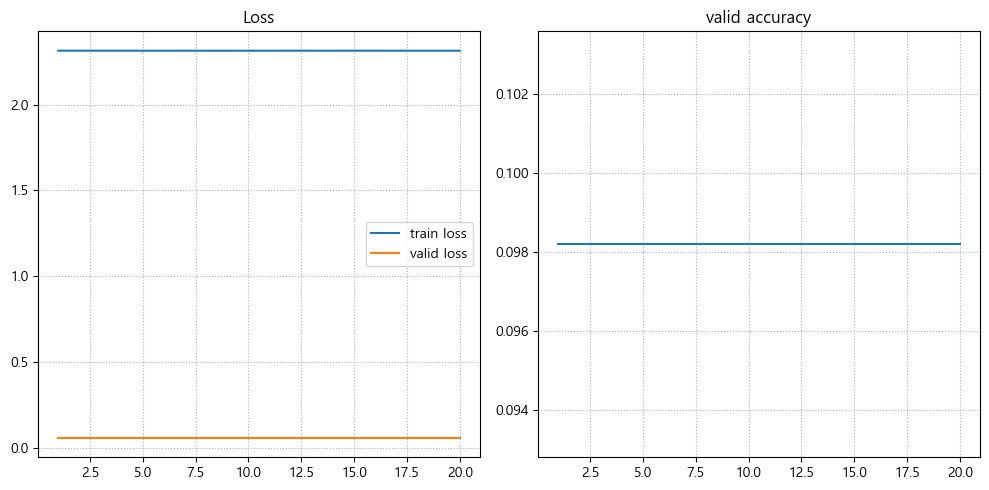

In [141]:
# train loss, valid loss, valid acc를 epoch별로 어떻게 변하는지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list, label="train loss")
plt.plot(range(1, epochs+1), valid_loss_list, label="valid loss")
plt.title("Loss")
plt.grid(True, linestyle=":")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), valid_acc_list)
plt.title("valid accuracy")

plt.tight_layout()
plt.grid(True, linestyle=":")
plt.show()

### 학습된 모델 저장 및 불러오기

In [79]:
import os
model_dir = "models"
save_path = os.path.join(model_dir, "mnist_model.pt")
save_path

'models\\mnist_model.pt'

In [80]:
# 모델 저장 : 파일 확장자 -pt, pth
torch.save(model, save_path) # (저장할모델, 파일명_저장경로)

In [81]:
# 저장된 모델 load(불러오기)
load_model = torch.load(save_path)
print(load_model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


C:\Users\Playdata\AppData\Local\Temp\ipykernel_15608\1575572777.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(save_path)


## 모델 성능 최종 평가

In [82]:
load_model = load_model.to(device)
load_model.eval() # 평가모드


test_loss = test_acc = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        
        # device 이동
        X_test, y_test = X_test.to(device), y_test.to(device)

        # 추론
        pred_test = load_model(X_test)

        # 검증 - loss
        loss_test = loss_fn(pred_test, y_test)
        test_loss += loss_test.item()
        
        # 검증 - accuracy
        ## class
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc += torch.sum(pred_test_class == y_test).item()

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(testset)

In [83]:
print(test_loss, test_acc)

2.315518283843994 0.0982


In [84]:
print(y_test.shape)
y_test

torch.Size([16])


tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [85]:
p = load_model(X_test)
p.shape

torch.Size([16, 10])

In [86]:
p_class = p.argmax(dim=-1)

In [87]:
torch.sum(y_test == p_class).item()  # 맞은 것의 갯수.

2

## 새로운 데이터 추론

In [116]:
from PIL import Image

def load_data(device="cpu", *path): # *path(가변인자) -  경로를 받는데 여러개의 인자를 받기 위해 지정.
    """
    1. 전달 받은 경로의 이미지 파일들을 읽는다.
    2. 28 x 28 로 resize
    3. totch.tensor로 변화 + 전처리
    4. device로 이동시킨 뒤 리턴
    """
    input_tensors = []
    for p in path:
        img = Image.open(p)
        img = img.convert("L")  # grayscale로 변환.
        img = img.resize((28, 28))  # 모델이 학습한 데이터 size(28, 28)로 변환.
        img = transforms.ToTensor()(img) # ToTensor()(img) class 객체를 생성하고 콜함수를 작성해야함.
        input_tensors.append(img)
    
    return torch.stack(input_tensors).to(device)


In [ ]:
# 위 코드 작성의 테스트용
# from PIL import Image
# import numpy as np


# a = Image.open("test_img/num/five.png") # 이미지를 읽어서 PIL.Image 객체로 반환
# a = a.convert("L")  # rgba => grayscale(L)
# a = a.resize((28, 28))
# print(type(a))
# a = transforms.ToTensor()(a)
# print(type(a))

# # an = np.array(a)
# a.shape   # (48: height, 51: width, 4: channel) -> (48, 51)
# a.max(), a.min()

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>


(tensor(1.), tensor(0.))

In [125]:
def predict(model, inputs, device="cpu"):
    """
    받은 model로 받은 inputsfmf 추론한 결과를 반환.
    결과를 class들을 반환.
    """
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        pred = model(inputs)
        pred_class = pred.argmax(dim=-1)
        return pred_class

        # print(pred.shape)
        # print(pred)
        # print(pred.argmax(dim=-1))

In [ ]:
# glob을 이용해 테스트 이미지들의 경로 조회.
from glob import glob
file_list = glob("test_img/**/*.png")  # 하위 디렉토리는 다 찾으려 할때는 **   # ("test_img/num/eight.png")
file_list

['test_img\\num\\eight.png',
 'test_img\\num\\eight2.png',
 'test_img\\num\\five.png',
 'test_img\\num\\four.png',
 'test_img\\num\\one.png',
 'test_img\\num\\seven.png',
 'test_img\\num\\seven2.png',
 'test_img\\num\\seven3.png',
 'test_img\\num\\three.png',
 'test_img\\num\\three2.png',
 'test_img\\num\\two.png',
 'test_img\\num\\two2.png']

In [131]:
r = load_data(device, *file_list)  # (device, "test_img/num/eight.png", "test_img/num/eight2.png")
# r.shape, r.min(), r.max()
result_pred = predict(load_model, r)
result_pred

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
# from sklearn.metrics import accuracy_score
# accuracy_score([8, 8], result_pred)   # 정답을 모르고 모델을 예측하기 떄문에 의미가 없는 결과임.

0.0

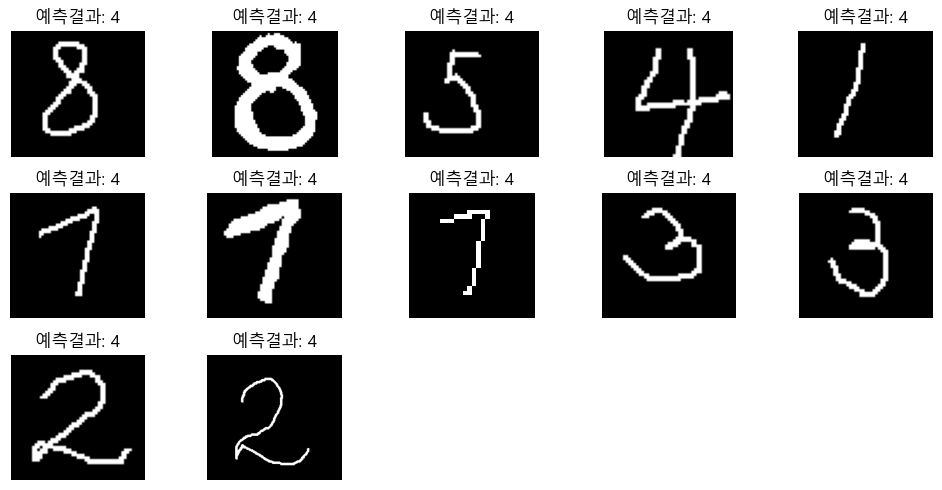

In [139]:
plt.figure(figsize=(10, 5))
for idx, (path, label) in enumerate(zip(file_list, result_pred)):
    # print(idx, path, label, sep=" , ")
    img = Image.open(path).convert('L')
    plt.subplot(3, 5, idx+1)  # 3, 4
    plt.imshow(img, cmap="gray")
    plt.title(f"예측결과: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# a(w(a(w(a(w X + b)))))